In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from itertools import product
from tqdm import tqdm

import Hawkes as hk

In [196]:
path =  'Data/RENA.PA/'

files = sorted([i for i in os.listdir(path) if 'trades' in i])

trades_list = [pd.read_csv(path + file,usecols=['ts','price','volume'],
                 parse_dates=True,index_col='ts') for file in files]

# 1. Visual inspection

#### 1.1 - Select as a sample the trade times of a part of the first days of your data. Fit a Hawkes model with a constant baseline intensity and a kernel with one exponential to this sample. Using the t trans() function of the package (and eventually the plot KS() function), comment on the goodness-of-fit of the model.

In [197]:
dates = trades_list[0].index[0:150]

start = pd.Timestamp("2017-01-02 09:00:00")


# calculate unix datetime
timestamps = np.sort(list((set((dates - start) // pd.Timedelta('1ms'))))) * 10**-3

end = timestamps[-1]

parameter: {'mu': 0.022671761324476316, 'alpha': 0.17526861858764392, 'beta': 15.095366610495555}
branching ratio: 0.17526861858764392


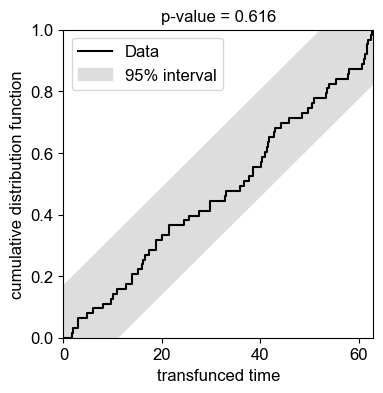

In [198]:
itv = [0,end]
model = hk.estimator().set_kernel('exp').set_baseline('const')
model.fit(timestamps,itv)

print("parameter:",model.parameter) # the estimated parameter values
print("branching ratio:",model.br) # the branching ratio
model.plot_KS()

Si le modèle estimé est correct, les temps d'occurrence des événements transformés, donnés comme $\{t'_i = \int_0^{t_i}\lambda(t|H_t)dt\}$, sont uniformément distribués dans l'intervalle $[0,\int_0^{l}\lambda(t|H_t)dt]$ ($l$ est la longueur de l'intervalle d'observation). Cette propriété nous permet de valider le modèle estimé.

La p-value obtenue lors de l'analyse est supérieure à 0,05, ce qui indique que l'hypothèse nulle ne peut pas être rejetée à ce niveau de confiance. donc les données des temps arrivées de cet échantillon sont bien ajustés par notre modèle 

#### 1.2 Try different parts / different sample length of the day.

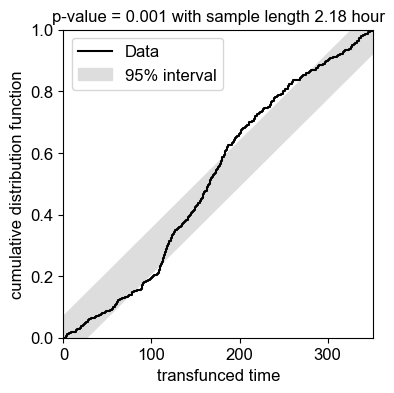

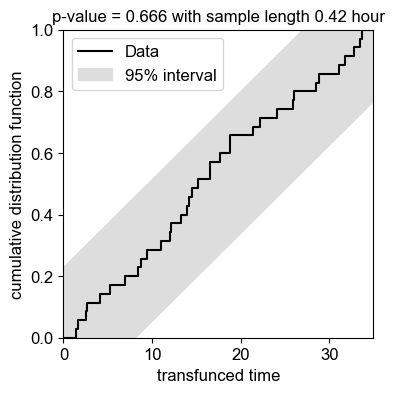

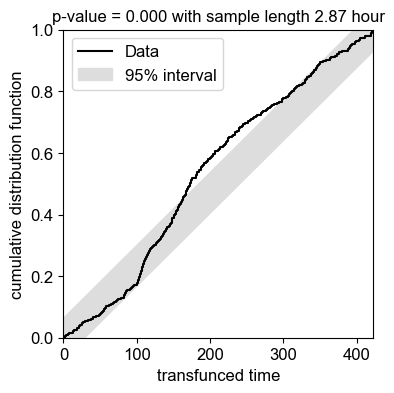

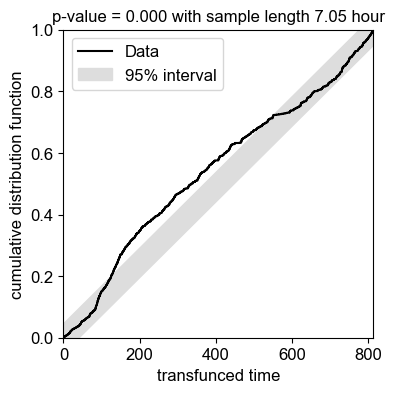

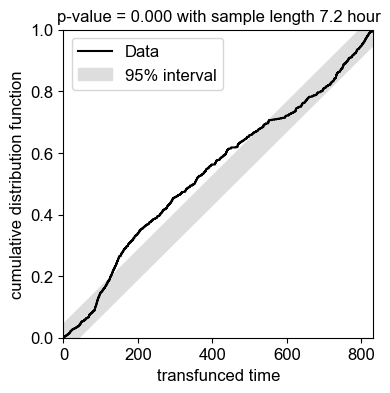

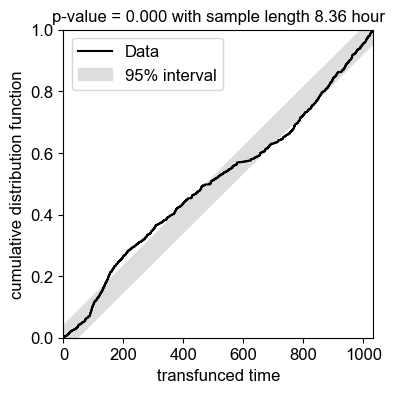

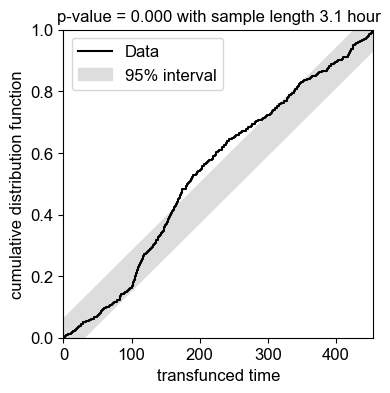

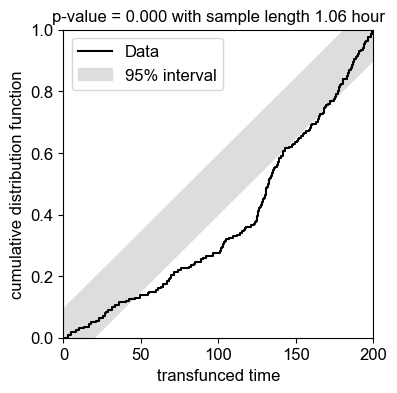

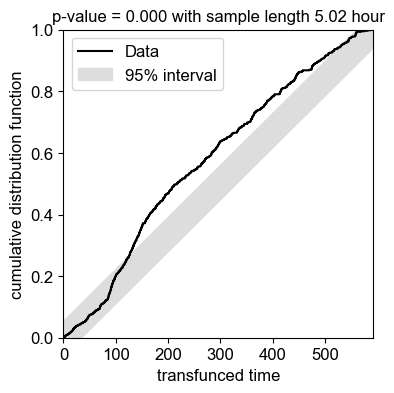

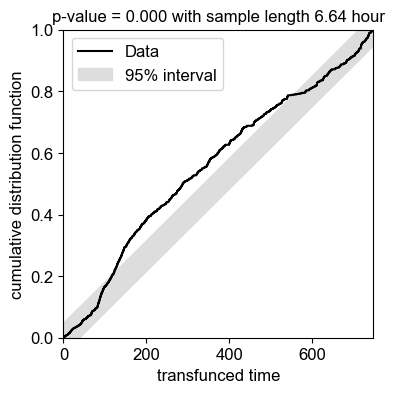

In [199]:

dates = trades_list[0].index
start = pd.Timestamp("2017-01-02 09:00:00")

for t_end in np.random.randint(20,len(dates),10):

    timestamps = np.sort(list((set((dates[0:t_end] - start) // pd.Timedelta('1ms'))))) * 10**-3

    end = timestamps[-1]
    itv = [0,end]
    model = hk.estimator().set_kernel('exp').set_baseline('const')
    model.fit(timestamps,itv)

    model.plot_KS()
    plt.title(plt.gca().get_title() + ' with sample length ' + str(round(end/3600,2)) + ' hour')

# 2. Systematic analysis.

#### 2.1 For each trading day, fit a Hawkes model with
 -  constant or piecewise linear baseline intensity ;
 -  an exponential kernel with 1, ..., 8 exponentials ;
 -  on a sample of length 0.25, 0.5, 1, 2, 4, 8 hours.


(Write a function and simply loop on it.)

In [200]:
def fit_hawkes(trading_day,baseline,num_basis,num_exp,sample_length):
    
    dates = trading_day.index

    day = dates[0].strftime('%Y-%m-%d')
    start = pd.Timestamp(day + " 09:00:00")
    
    # calculate unix datetime
    timestamps = np.sort(list((set((dates - start) // pd.Timedelta('1ms'))))) * 10**-3
    timestamps = timestamps[timestamps<=sample_length*3600]
    
    t_end = timestamps[-1]
    
    
    if num_basis==1 and baseline == 'pconst':
        model = hk.estimator().set_kernel('exp',num_exp=num_exp).set_baseline('const')
    else:
        model = hk.estimator().set_kernel('exp',num_exp=num_exp).set_baseline(baseline,num_basis=num_basis)
        
    model.fit(timestamps,[0,t_end])
    model.plot_KS()
    
    pvalue = float(plt.gca().get_title().split(' ')[2])
    
    results = {"Day":day,"sample_length":sample_length,"baseline":baseline,"num_basis":num_basis,"num_exp":num_exp,
               "branching ratio": model.br,"AIC":model.AIC,'pvalue':pvalue,"log-likelihood":model.L}
    
    return results

In [201]:
def fit_data():
    import matplotlib
    matplotlib.use('Agg')
    
    baseline_list = {'plinear' : np.arange(2,4),'pconst' : np.arange(1,4)}
    number_basis_list = np.arange(1,3)
    number_exp_list = np.arange(1,9)
    sample_length_list = [0.25,0.5,2,4,8]



    df = pd.DataFrame()

    for baseline,number_basis_list in baseline_list.items():
        for sample_length in sample_length_list:

            for num_exp in tqdm(number_exp_list):

                for num_basis in number_basis_list:

                    for trading_day in trades_list:
                        results = fit_hawkes(trading_day,baseline,num_basis,num_exp,sample_length)

                        results_df = pd.DataFrame(results, index=[0])

                        df = pd.concat([df, results_df], ignore_index=True)
                        
    df.to_csv('results.csv', index=False)
    return df

In [202]:
if 'results.csv' in os.listdir('.'):
    df = pd.read_csv('results.csv')
else:
    df = fit_data()
df

,Day,sample_length,baseline,num_basis,num_exp,branching ratio,AIC,pvalue,log-likelihood
0,2017-01-02,0.25,plinear,2,1,0.185392,174.845926,0.981,-84.422963
1,2017-01-03,0.25,plinear,2,1,0.253285,495.340767,0.092,-244.670384
2,2017-01-04,0.25,plinear,2,1,0.410000,278.701322,0.575,-136.350661
3,2017-01-05,0.25,plinear,2,1,0.210765,624.593760,0.175,-309.296880
4,2017-01-06,0.25,plinear,2,1,0.347286,415.191944,0.212,-204.595972
...,...,...,...,...,...,...,...,...,...
4395,2017-01-25,8.00,pconst,3,8,0.643831,19430.612352,0.016,-9712.306176
4396,2017-01-26,8.00,pconst,3,8,0.832872,15204.828559,0.629,-7599.414279
4397,2017-01-27,8.00,pconst,3,8,0.818631,13973.696772,0.285,-6983.848386
4398,2017-01-30,8.00,pconst,3,8,0.840397,13169.393581,0.193,-6581.696790


#### 2.2 How frequently is a statistical test of goodness-of-fit passed ?


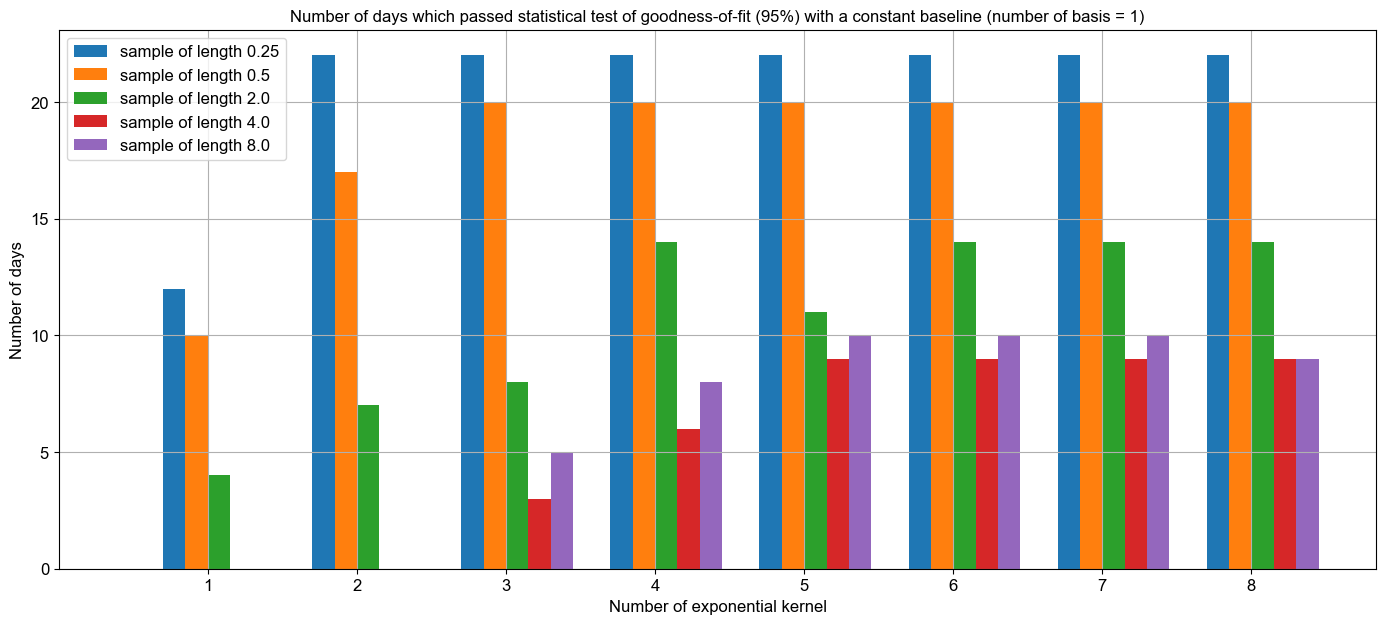

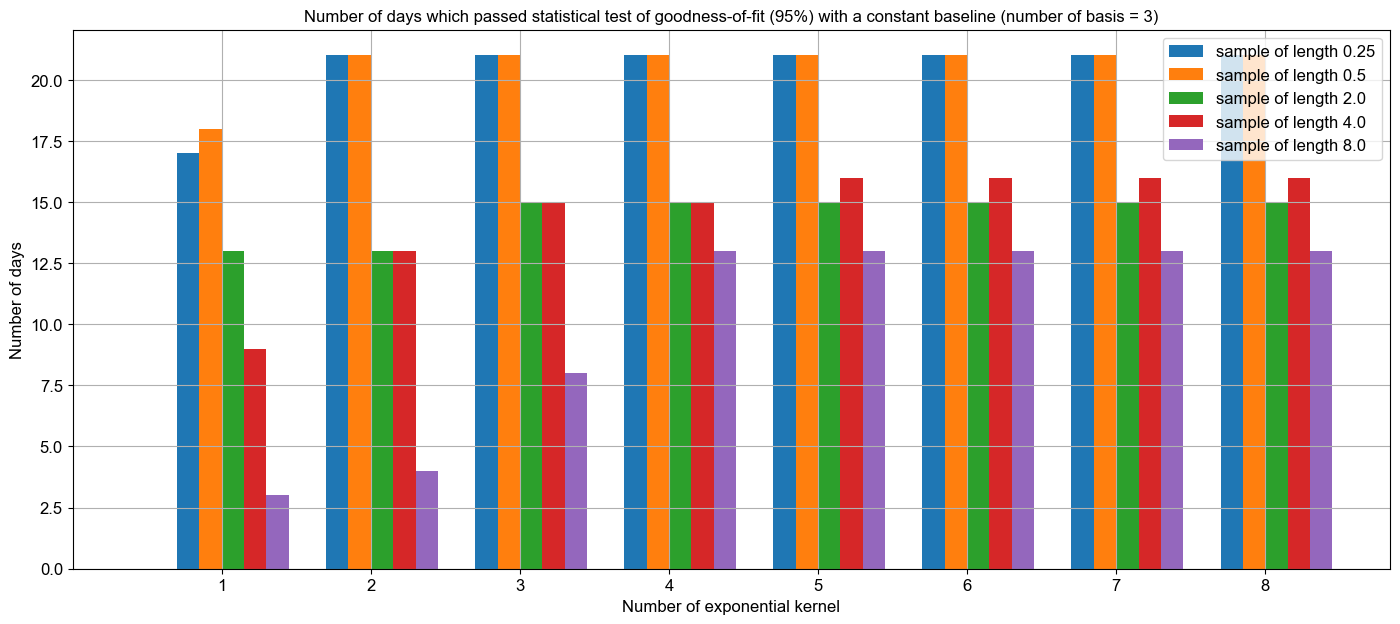

In [203]:
# Data
variables = dict()
for dt in df['sample_length'].unique():
    variable = df[ (df['num_basis']==1)& (df['sample_length'] == dt)&(df['baseline']=='pconst') &
                  (df['pvalue']>0.05)].groupby('num_exp')['Day'].count()
    variables[dt] = variable
    
labels = [str(i) for i in range(1,9)]



# Create the bar plot

fig, ax = plt.subplots(figsize=(17,7))

# Width of each bar
width = 0.15
i=-1.5
for key,value in variables.items() :
    x = value.index
    rects1 = ax.bar(x + i*width, value, width, label='sample of length ' + str(key))
    i+=1

# Add labels, title, and legend
ax.set_ylabel('Number of days')
ax.set_title('Number of days which passed statistical test of goodness-of-fit (95%) with a constant baseline (number of basis = 1)')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Number of exponential kernel')
ax.legend()

# Group the bars together
plt.xticks(np.arange(1,len(labels)+1), labels)
plt.legend()
plt.grid()


variables = dict()
for dt in df['sample_length'].unique():
    variable = df[ (df['num_basis']==3)& (df['sample_length'] == dt)&(df['baseline']=='pconst') &
                  (df['pvalue']>0.05)].groupby('num_exp')['Day'].count()
    variables[dt] = variable
    
labels = [str(i) for i in range(1,9)]

fig, ax = plt.subplots(figsize=(17,7))

# Width of each bar
width = 0.15
i=-1.5
for key,value in variables.items() :
    x = value.index
    rects1 = ax.bar(x + i*width, value, width, label='sample of length ' + str(key))
    i+=1

# Add labels, title, and legend
ax.set_ylabel('Number of days')
ax.set_title('Number of days which passed statistical test of goodness-of-fit (95%) with a constant baseline (number of basis = 3)')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Number of exponential kernel')
ax.legend()

# Group the bars together
plt.xticks(np.arange(1,len(labels)+1), labels)
plt.legend()
plt.grid()


### Commentaire
Ces deux graphes présentent le nombre de jours où les données ont passé le test statistique en fonction du nombre de noyaux exponentiels et de la taille de l'échantillon.

Dans le premier graphe, qui utilise un baseline constant, on remarque que le nombre de jours passant le test statistique augmente avec le nombre de noyaux exponentiels et diminue avec la taille de l'échantillon. Il n'y a aucun jour où les données passent le test statistique pour un échantillon supérieur ou égal à 4 heures et un nombre d'exponentiels inférieur ou égal à 2. Pour les petits échantillons, le "goodness of fit" est toujours vraie, sauf pour un seul noyau exponentiel, pour lequel 12 ou 13 jours parmi les 22 jours ont passé le test.

Pour un nombre de noyaux supérieur à 4, on n'observe pas une croissance significative dans le nombre de jours pour les grands échantillons (4 heures ou 8 heures). Même avec un grand nombre de noyaux exponentiels, il n'y a qu'environ 10 jours qui passent le test pour les grands échantillons.

Dans le deuxième graphe, on utilise un baseline constant par morceaux (3 morceaux). Contrairement au premier graphe, on observe que des jours passent toujours le test statistique à 5%, même pour les grands échantillons.

On remarque également que le nombre de jours est supérieur à celui du premier graphe. Il n'y a pas de croissance significative du nombre de jours lorsque le nombre de noyaux est supérieur à 4.

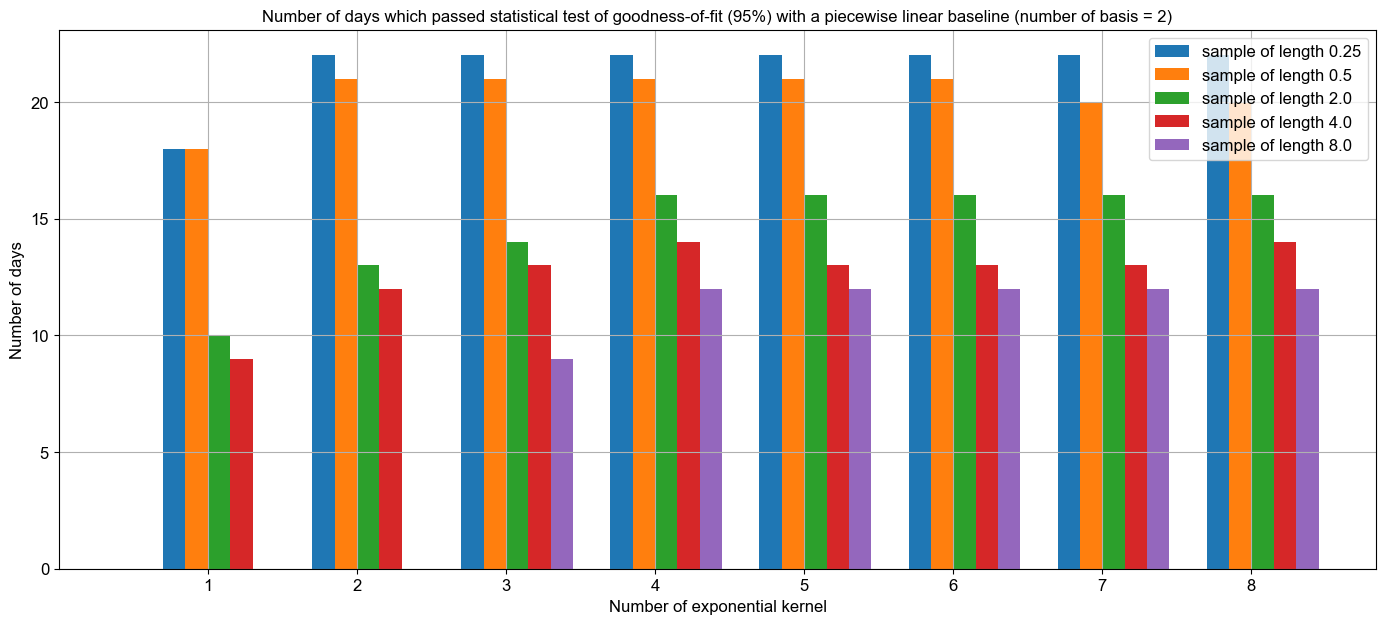

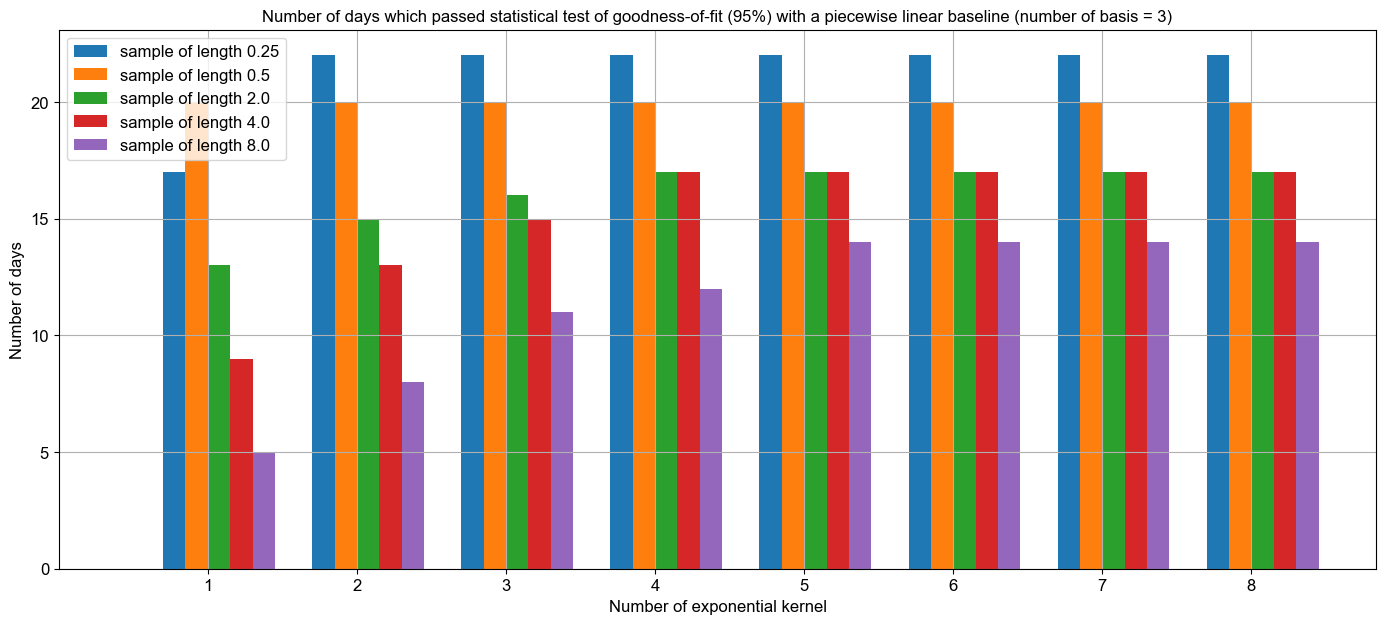

In [204]:
# Data
variables = dict()
for dt in df['sample_length'].unique():
    variable = df[ (df['num_basis']==2)& (df['sample_length'] == dt)&(df['baseline']=='plinear') &
                  (df['pvalue']>0.05)].groupby('num_exp')['Day'].count()
    variables[dt] = variable
    
labels = [str(i) for i in range(1,9)]



# Create the bar plot

fig, ax = plt.subplots(figsize=(17,7))

# Width of each bar
width = 0.15
i=-1.5
for key,value in variables.items() :
    x = value.index
    rects1 = ax.bar(x + i*width, value, width, label='sample of length ' + str(key))
    i+=1

# Add labels, title, and legend
ax.set_ylabel('Number of days')
ax.set_title('Number of days which passed statistical test of goodness-of-fit (95%) with a piecewise linear baseline (number of basis = 2)')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Number of exponential kernel')
ax.legend()

# Group the bars together
plt.xticks(np.arange(1,len(labels)+1), labels)
plt.legend()
plt.grid()


variables = dict()
for dt in df['sample_length'].unique():
    variable = df[ (df['num_basis']==3)& (df['sample_length'] == dt)&(df['baseline']=='plinear') &
                  (df['pvalue']>0.05)].groupby('num_exp')['Day'].count()
    variables[dt] = variable
    
labels = [str(i) for i in range(1,9)]

fig, ax = plt.subplots(figsize=(17,7))

# Width of each bar
width = 0.15
i=-1.5
for key,value in variables.items() :
    x = value.index
    rects1 = ax.bar(x + i*width, value, width, label='sample of length ' + str(key))
    i+=1

# Add labels, title, and legend
ax.set_ylabel('Number of days')
ax.set_title('Number of days which passed statistical test of goodness-of-fit (95%) with a piecewise linear baseline (number of basis = 3)')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Number of exponential kernel')
ax.legend()

# Group the bars together
plt.xticks(np.arange(1,len(labels)+1), labels)
plt.legend()
plt.grid()


Dans ces deux graphes, on utilise un baseline constant par morceaux( 1 morceaux pour le premier graphe et 3 morceaux pour le 2ème ).

On observe des nombres de jour supérieurs à ceux des graphes précedants.

#### 2.3 [6] finds that statistical significance in high-frequency requires multiple exponential kernels for datasets of several hours. Is this in line with your observations ?

Les graphes précédents montrent que pour le baseline constant par morceaux ou le baseline linéaire par morceaux, afin que le test statistique soit passé un grand nombre de fois pour les grands échantillons, plusieurs noyaux exponentiels sont nécessaires. Le nombre d'exponentiels auquel le nombre de jours se stabilise est de 4.

Par conséquent, nos observations sont compatibles avec les résultats de [6].

#### 2.4 Analyze the median branching ratios per sample length, baseline and exponential.

we will take a number of basis equal to 3 from now on

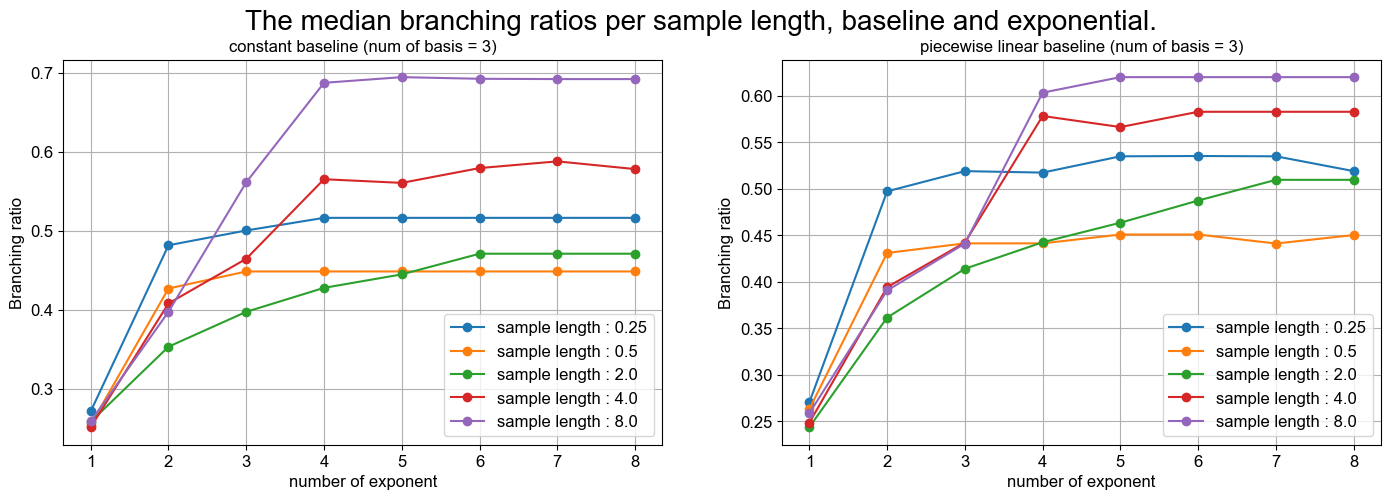

In [205]:
variables = dict()
for dt in df['sample_length'].unique():
    variable = df[ (df['num_basis']==3)& (df['sample_length'] == dt)&(df['baseline']=='pconst') &
                  (df['pvalue']>0.05)].groupby('num_exp')['branching ratio'].median()
    variables[dt] = variable




fig, axs = plt.subplots(1,2, figsize=(17, 5))
title = 'The median branching ratios per sample length, baseline and exponential.'
fig.suptitle(title,fontsize = 20)
    
axs[0].set_title('constant baseline (num of basis = 3)')
variables = dict()
for dt in df['sample_length'].unique():
    variable = df[ (df['num_basis']==3)& (df['sample_length'] == dt)&(df['baseline']=='pconst') &
                  (df['pvalue']>0.05)].groupby('num_exp')['branching ratio'].median()
    variables[dt] = variable
    
for sample_length,median_br in variables.items():
    axs[0].plot(np.arange(1,9),median_br,label='sample length : ' + str(sample_length),marker='o')

axs[0].set_xlabel('number of exponent')
axs[0].set_ylabel('Branching ratio')
axs[0].grid()
axs[0].legend()
    
axs[1].set_title('piecewise linear baseline (num of basis = 3)')
variables = dict()
for dt in df['sample_length'].unique():
    variable = df[ (df['num_basis']==3)& (df['sample_length'] == dt)&(df['baseline']=='plinear') &
                  (df['pvalue']>0.05)].groupby('num_exp')['branching ratio'].median()
    variables[dt] = variable
    
for sample_length,median_br in variables.items():
    axs[1].plot(np.arange(1,9),median_br,label='sample length : ' + str(sample_length),marker='o')

axs[1].set_xlabel('number of exponent')
axs[1].set_ylabel('Branching ratio')
axs[1].grid()
axs[1].legend()

    


Le branching ratio mesure la relation entre le nombre moyen d'événements générés par un événement parent et le nombre moyen d'événements attendus dans l'ensemble du processus. Il est donc utilisé pour déterminer si le processus a une dynamique explosive ou non.

Un branching ratio supérieur à 1 indique que le processus a une dynamique explosive, ce qui signifie que chaque événement parent génère en moyenne plus d'un événement, et donc le nombre d'événements dans le processus augmente de manière exponentielle. En revanche, un branching ratio inférieur à 1 indique que le processus est stable et que le nombre d'événements a une croissance limitée.

Les deux baselines présentent un branching ratio inférieur à 1 pour tout paramètre choisi, indiquant ainsi que le processus modélisé est stable.

Le branching ratio augmente avec le nombre de noyaux exponentiels, mais l'évolution en fonction de la taille de l'échantillon n'est pas claire d'après les graphes.

L'allure du branching ratio en fonction du nombre d'exponentiels ne semble pas varier lorsque l'on change de baseline.

L'application de "the elbow trick" à ces graphes pour les grands échantillons suggère de choisir 4 comme nombre d'exponentiels optimal.

#### 2.5 Analyze the median number of exponentials selected by AIC per sample length and baseline.

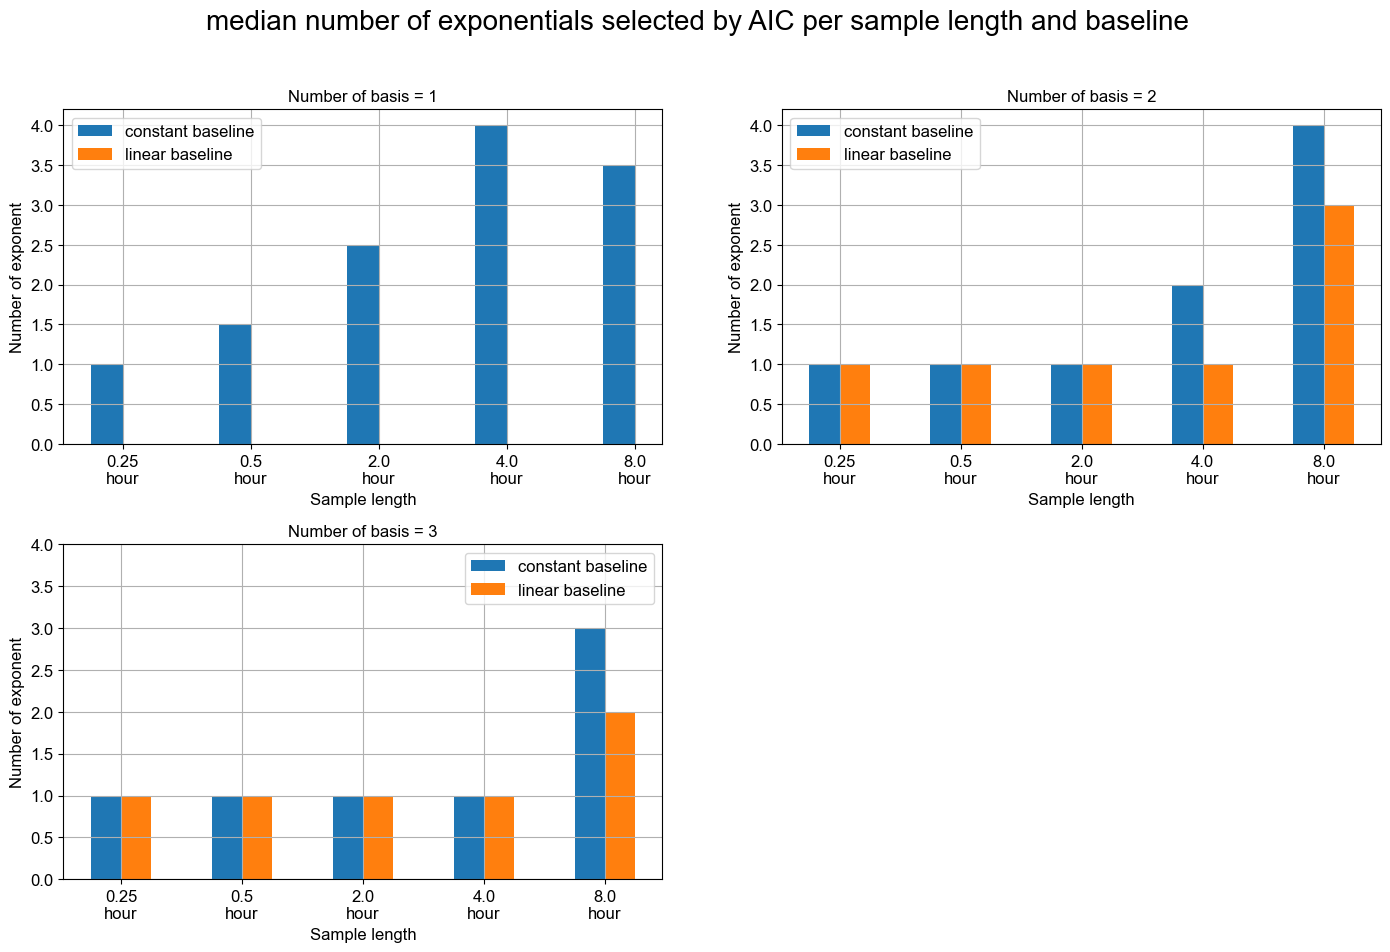

In [206]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(17,10))
fig.suptitle('median number of exponentials selected by AIC per sample length and baseline ',fontsize = 20)


for i in range(1,4):
    baseline_c = dict()
    for dt in df['sample_length'].unique():
        variable = df[ (df['num_basis']==i)& (df['sample_length'] == dt)&(df['baseline']=='pconst') &
                      (df['pvalue']>0.05)].groupby('Day').min('AIC')['num_exp'].median()
        baseline_c[dt] = variable
        
    baseline_l = dict()    
    for dt in df['sample_length'].unique():
        variable = df[ (df['num_basis']==i)& (df['sample_length'] == dt)&(df['baseline']=='plinear') &
                      (df['pvalue']>0.05)].groupby('Day').min('AIC')['num_exp'].median()
        baseline_l[dt] = variable     
        
    sample_length = list(baseline_c.keys())
    med_exp_c = list(baseline_c.values())
    med_exp_l = list(baseline_l.values())

    axes[(i-1)//2,(i-1)%2].bar(np.arange(len(med_exp))-0.125,med_exp_c,width=0.25,label='constant baseline')
    axes[(i-1)//2,(i-1)%2].bar(np.arange(len(med_exp))+0.125,med_exp_l,width=0.25,label='linear baseline')
    
    
    
    xticks = np.arange(len(med_exp))
    xticklabels = [str(j) + '\nhour' for j in sample_length]
    yticks = [0.5*i for i in range(0,9)]
    
    axes[(i-1)//2,(i-1)%2].set_xticks(xticks)
    axes[(i-1)//2,(i-1)%2].set_xticklabels(xticklabels)
    axes[(i-1)//2,(i-1)%2].set_yticks(yticks)
    
    axes[(i-1)//2,(i-1)%2].set_xlabel('Sample length')
    axes[(i-1)//2,(i-1)%2].set_ylabel('Number of exponent')
    axes[(i-1)//2,(i-1)%2].set_title('Number of basis = '+str(i))
    axes[(i-1)//2,(i-1)%2].legend()
    axes[(i-1)//2,(i-1)%2].grid()
    

axes[1,1].set_axis_off()



plt.subplots_adjust(hspace=0.3)

D'après ces graphes, on peut conclure qu'un seul noyau suffit pour modéliser les petits échantillons, tandis que pour les grands échantillons, il est préférable d'en utiliser plusieurs (4 selon les graphes précédents).

En augmentant le nombre de morceaux du baseline, le modèle dispose de plus de degrés de liberté pour modéliser les données, ce qui compense le besoin en noyaux exponentiels.

Le modèle avec un baseline linéaire par morceaux nécessite moins de noyaux exponentiels que le modèle avec un baseline constant par morceaux.

## Conclusion

D'après notre anlayse des graphes, on choisira pour notre modélisation les paramètres suivants:
- sample length = 8 heures
- baseline = linéaire par morceaux ( 2 morceaux)
- nombre d'exponentiels = 4